# Evaluate Rep Counter 

Utilize infinity AI synthetic data to evaluate rep counting capabilities of the chosen model.

In [1]:
# General imports
import cv2
import mediapipe as mp
import numpy as np
import os
import sys
from datetime import datetime, date
import time
import uuid
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import pandas as pd
pd.set_option('display.max_columns', 500)


# data processing and visualization helper functions
from processing import process_image, process_video
from data_acquisition import capture_session
from visualization import plot_ROM_dtw_comparisons, calc_DTW_joints_metrics, create_3D_keypoints_video, plot_ex_animation


# Request handling and data payload packaging
from django.core.serializers.json import DjangoJSONEncoder
import json
import requests
import pprint

import rep_counter

pp = pprint.PrettyPrinter(indent=4)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
EXERCISE_MAPPING = {'BICEP_CURL-ALTERNATING-DUMBBELL': 'BICEP_CURL',
                    'LEG_RAISE':'LEG_RAISE',
                    'ARM_RAISE-DUMBBELL':'ARM_RAISE',
                    'SQUAT-BODYWEIGHT':'SQUAT'
}

In [3]:
output = []

def get_rep_count(row):
    video_path = os.path.join(row['job_path'],'video.rgb.mp4')
    exercise = EXERCISE_MAPPING[row['exercise']]

    flag, video_output = process_video(video_path)

    if not flag:
        assert("can't process video")
    
    flag, result = rep_counter.calculate_reps(video_output['pose_landmarks'], row['image_width'], row['image_height'], exercise)
    output.append(result)
    # print(result['reps_frame_array'])
    
    return result['detected_reps']

In [4]:
base_result_folder = './intitial_rep_test_results'

### SQUAT

In [5]:
DATA_FOLDER = './rep_count_tmp'

batch_folder = './rep_count_tmp/20230109_T010544835405_squat_rep_count_test_data'

df = pd.read_csv(os.path.join(batch_folder,'summary.csv'))

In [6]:
df['detected_reps'] = df.apply(get_rep_count, axis=1)

df.to_csv(os.path.join(batch_folder,'summary_with_reps.csv'), index=False)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [7]:
# path = os.path.join(base_result_folder, 'squat_rep_test_initial.json')
# with open(path, 'w') as f:
#     json.dump(output, f, indent=4)

In [8]:
# reset output 
output = []

## ARM RAISE

In [ ]:
batch_folder = './rep_count_tmp/20230109_T011742449572_arm_raise_rep_count_test_data'
df = pd.read_csv(os.path.join(batch_folder,'summary.csv'))
df['detected_reps'] = df.apply(get_rep_count, axis=1)
df.to_csv(os.path.join(batch_folder,'summary_with_reps.csv'), index=False)

path = os.path.join(base_result_folder, 'arm_raise_rep_test_initial.json')
with open(path, 'w') as f:
    json.dump(output, f, indent=4)

output = []

## BICEP CURL

In [13]:
batch_folder = './rep_count_tmp/20230109_T012151981034_bicep_curl_rep_count_test_data'
df = pd.read_csv(os.path.join(batch_folder,'summary.csv'))
df['detected_reps'] = df.apply(get_rep_count, axis=1)
df.to_csv(os.path.join(batch_folder,'summary_with_reps.csv'), index=False)

path = os.path.join(base_result_folder, 'bicep_curl_rep_test_initial.json')
with open(path, 'w') as f:
    json.dump(output, f, indent=4)

output = []

## LEG RAISE

In [17]:
batch_folder = './rep_count_tmp/20230109_T013138980161_leg_raise_rep_count_test_data'
df = pd.read_csv(os.path.join(batch_folder,'summary.csv'))
df['detected_reps'] = df.apply(get_rep_count, axis=1)
df.to_csv(os.path.join(batch_folder,'summary_with_reps.csv'), index=False)

path = os.path.join(base_result_folder, 'leg_raise_rep_test_initial.json')
with open(path, 'w') as f:
    json.dump(output, f, indent=4)

output = []

## Aggregation and results

In [2]:
batch_folders = ['./rep_count_tmp/20230109_T010544835405_squat_rep_count_test_data', 
                './rep_count_tmp/20230109_T011742449572_arm_raise_rep_count_test_data',
                './rep_count_tmp/20230109_T012151981034_bicep_curl_rep_count_test_data',
                './rep_count_tmp/20230109_T013138980161_leg_raise_rep_count_test_data']


dfs = [pd.read_csv(os.path.join(f,'summary_with_reps.csv')) for f in batch_folders]

df_agg = pd.concat(dfs, ignore_index=True)

In [8]:
# Get performance statistics
df_agg['detected_one_rep'] = df_agg['detected_reps'] > 0
df_agg['detected_all_reps'] = df_agg['detected_reps'] == df_agg['num_reps']
overall_accuracy = df_agg['detected_reps'].sum()/df_agg['num_reps'].sum()

detection_rate = df_agg['detected_one_rep'].sum()/len(df_agg['detected_one_rep'])

print(f"Overall Accuracy: {overall_accuracy:.3f}")
print(f"Detection Rate: {detection_rate:.3f}")

Overall Accuracy: 0.883
Detection Rate: 0.933


In [4]:
# See which cases don't detect a single rep
df_agg[df_agg['detected_reps'] == 0]

,job_path,job_id,num_frames,avg_percent_in_fov,avg_percent_occlusion,scene,exercise,gender,num_reps,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,camera_distance,camera_height,avatar_identity,relative_height,relative_weight,relative_camera_yaw_deg,relative_camera_pitch_deg,lighting_power,relative_avatar_angle_deg,frame_rate,image_width,image_height,seconds_per_rep,detected_reps,Unnamed: 0,detected_one_rep,detected_all_reps
47,./rep_count_tmp/20230109_T011742449572_arm_rai...,7860139c-f7c9-4422-b28a-26c96918d221,63.0,10.394211,2.466125,BEDROOM_2,ARM_RAISE-DUMBBELL,MALE,2.0,1.469579,0.169066,0.0,0.0,0.031380,3.203848,0.549604,19.0,0.097011,-1.116881,2.121931,-25.669951,329.397113,28.740589,12.0,256.0,256.0,1.0,0,17.0,False,False
64,./rep_count_tmp/20230109_T012151981034_bicep_c...,95b24a14-7ce8-43ef-b157-2da7ebf07837,51.0,100.000000,4.546265,BEDROOM_2,BICEP_CURL-ALTERNATING-DUMBBELL,MALE,2.0,1.881466,0.173556,0.0,0.0,0.704333,4.976901,1.382491,0.0,-0.900726,-0.772442,-7.818848,2.532717,124.720468,76.039002,12.0,256.0,256.0,1.0,0,NaN,False,False
78,./rep_count_tmp/20230109_T012151981034_bicep_c...,33e141e6-d147-4f32-95db-2064b4a06dab,184.0,100.000000,3.760594,BEDROOM_2,BICEP_CURL-ALTERNATING-DUMBBELL,FEMALE,2.0,0.517263,0.269819,0.0,0.0,0.199025,4.156485,1.264641,1.0,1.653976,-1.473108,-5.338433,3.846957,415.132298,79.835847,12.0,256.0,256.0,1.0,0,NaN,False,False
85,./rep_count_tmp/20230109_T012151981034_bicep_c...,eab22728-31b1-44e8-b52c-5e4aa27d1e9b,160.0,99.969869,3.056037,BEDROOM_4,BICEP_CURL-ALTERNATING-DUMBBELL,MALE,2.0,0.731210,0.743172,0.0,0.0,0.154126,3.559959,1.193636,5.0,1.233700,0.166134,1.769044,-8.032070,328.266898,87.371732,12.0,256.0,256.0,1.0,0,NaN,False,False
89,./rep_count_tmp/20230109_T012151981034_bicep_c...,d523c3af-d7c3-4f65-b2dc-0b6fa7209162,135.0,100.000000,18.817733,GYM_1,BICEP_CURL-ALTERNATING-DUMBBELL,MALE,2.0,0.710886,0.531151,0.0,0.0,0.138993,3.557289,0.504431,14.0,0.926881,1.226958,-9.450574,-5.024104,417.227896,51.850968,12.0,256.0,256.0,1.0,0,NaN,False,False
91,./rep_count_tmp/20230109_T013138980161_leg_rai...,dbe6c902-0c60-4bd0-9de6-bb3c2b87bb65,22.0,41.628119,61.063000,GYM_1,LEG_RAISE,FEMALE,2.0,1.932634,0.430104,0.0,0.0,0.306136,3.665674,0.640981,3.0,-1.023697,-0.538971,-16.968594,-0.599493,221.310073,41.531765,12.0,256.0,256.0,1.0,0,NaN,False,False
100,./rep_count_tmp/20230109_T013138980161_leg_rai...,febcc919-9206-4a41-a97f-10f5922276b1,65.0,100.000000,78.048031,BEDROOM_5,LEG_RAISE,FEMALE,2.0,0.777384,0.797051,0.0,0.0,0.267212,3.745324,0.830215,15.0,0.200974,-1.352381,2.360877,8.765548,59.752740,-9.018411,12.0,256.0,256.0,1.0,0,NaN,False,False
109,./rep_count_tmp/20230109_T013138980161_leg_rai...,6781c0f3-2ad4-4063-8740-09a6130ab4b0,26.0,100.000000,67.893590,BEDROOM_5,LEG_RAISE,FEMALE,2.0,1.953518,0.496239,0.0,0.0,0.945583,4.680783,0.532861,13.0,-1.110316,0.687099,-1.488494,-7.411641,318.329171,-83.141835,12.0,256.0,256.0,1.0,0,NaN,False,False


In [5]:
# Analyze relative angle here 

In [6]:
# Segment performance by individual exercises
df_ex = df_agg.groupby('exercise').agg({'num_frames':np.mean,'num_reps':np.sum,'detected_reps':np.sum, 'detected_one_rep':np.sum, 'job_id': lambda x: len(x)})
df_ex['accuracy'] = df_ex['detected_reps']/df_ex['num_reps']
df_ex['detection_rate'] = df_ex['detected_one_rep']/df_ex['job_id']
df_ex

,num_frames,num_reps,detected_reps,detected_one_rep,job_id,accuracy,detection_rate
exercise,,,,,,,
ARM_RAISE-DUMBBELL,86.433333,60.0,58,29,30,0.966667,0.966667
BICEP_CURL-ALTERNATING-DUMBBELL,92.666667,60.0,51,26,30,0.850000,0.866667
LEG_RAISE,37.733333,60.0,48,27,30,0.800000,0.900000
SQUAT-BODYWEIGHT,44.700000,60.0,55,30,30,0.916667,1.000000


In [ ]:
df['detected']

<AxesSubplot: xlabel='rel_baseline_speed', ylabel='Count'>

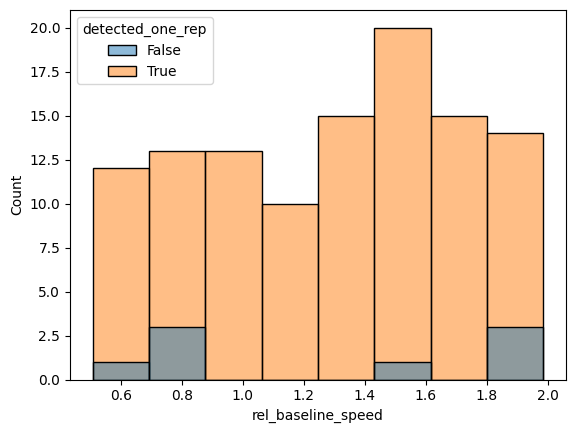

In [22]:
sns.histplot(data=df_agg, x='rel_baseline_speed', hue='detected_one_rep')

<AxesSubplot: xlabel='relative_avatar_angle_deg', ylabel='Count'>

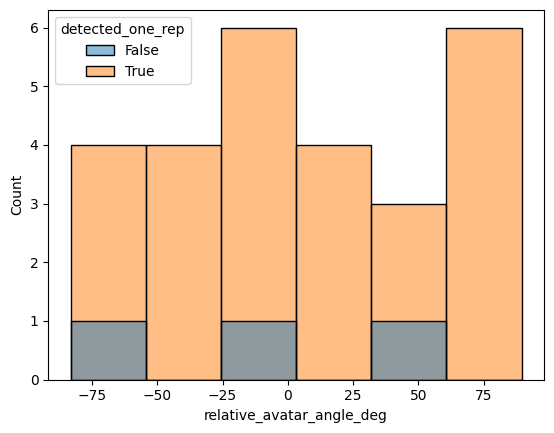

In [21]:
sns.histplot(data=df_agg[df_agg['exercise']=='LEG_RAISE'], x='relative_avatar_angle_deg', hue='detected_one_rep')

<AxesSubplot: xlabel='relative_avatar_angle_deg', ylabel='Count'>

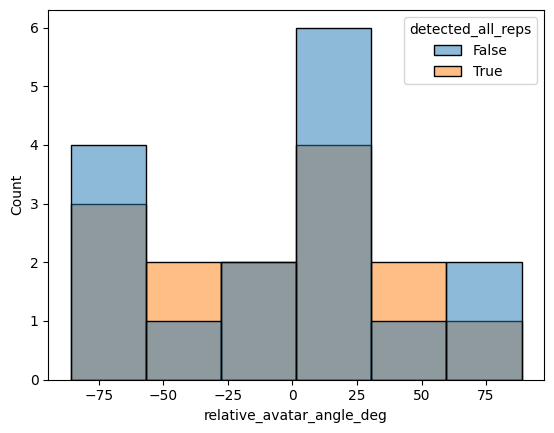

In [40]:
sns.histplot(data=df_agg[df_agg['exercise']=='SQUAT-BODYWEIGHT'], x='relative_avatar_angle_deg', hue='detected_all_reps')

array([[<AxesSubplot: title={'center': 'num_frames'}>,
        <AxesSubplot: title={'center': 'avg_percent_in_fov'}>,
        <AxesSubplot: title={'center': 'avg_percent_occlusion'}>,
        <AxesSubplot: title={'center': 'num_reps'}>,
        <AxesSubplot: title={'center': 'rel_baseline_speed'}>],
       [<AxesSubplot: title={'center': 'max_rel_speed_change'}>,
        <AxesSubplot: title={'center': 'trim_start_frac'}>,
        <AxesSubplot: title={'center': 'trim_end_frac'}>,
        <AxesSubplot: title={'center': 'kinematic_noise_factor'}>,
        <AxesSubplot: title={'center': 'camera_distance'}>],
       [<AxesSubplot: title={'center': 'camera_height'}>,
        <AxesSubplot: title={'center': 'avatar_identity'}>,
        <AxesSubplot: title={'center': 'relative_height'}>,
        <AxesSubplot: title={'center': 'relative_weight'}>,
        <AxesSubplot: title={'center': 'relative_camera_yaw_deg'}>],
       [<AxesSubplot: title={'center': 'relative_camera_pitch_deg'}>,
        <Ax

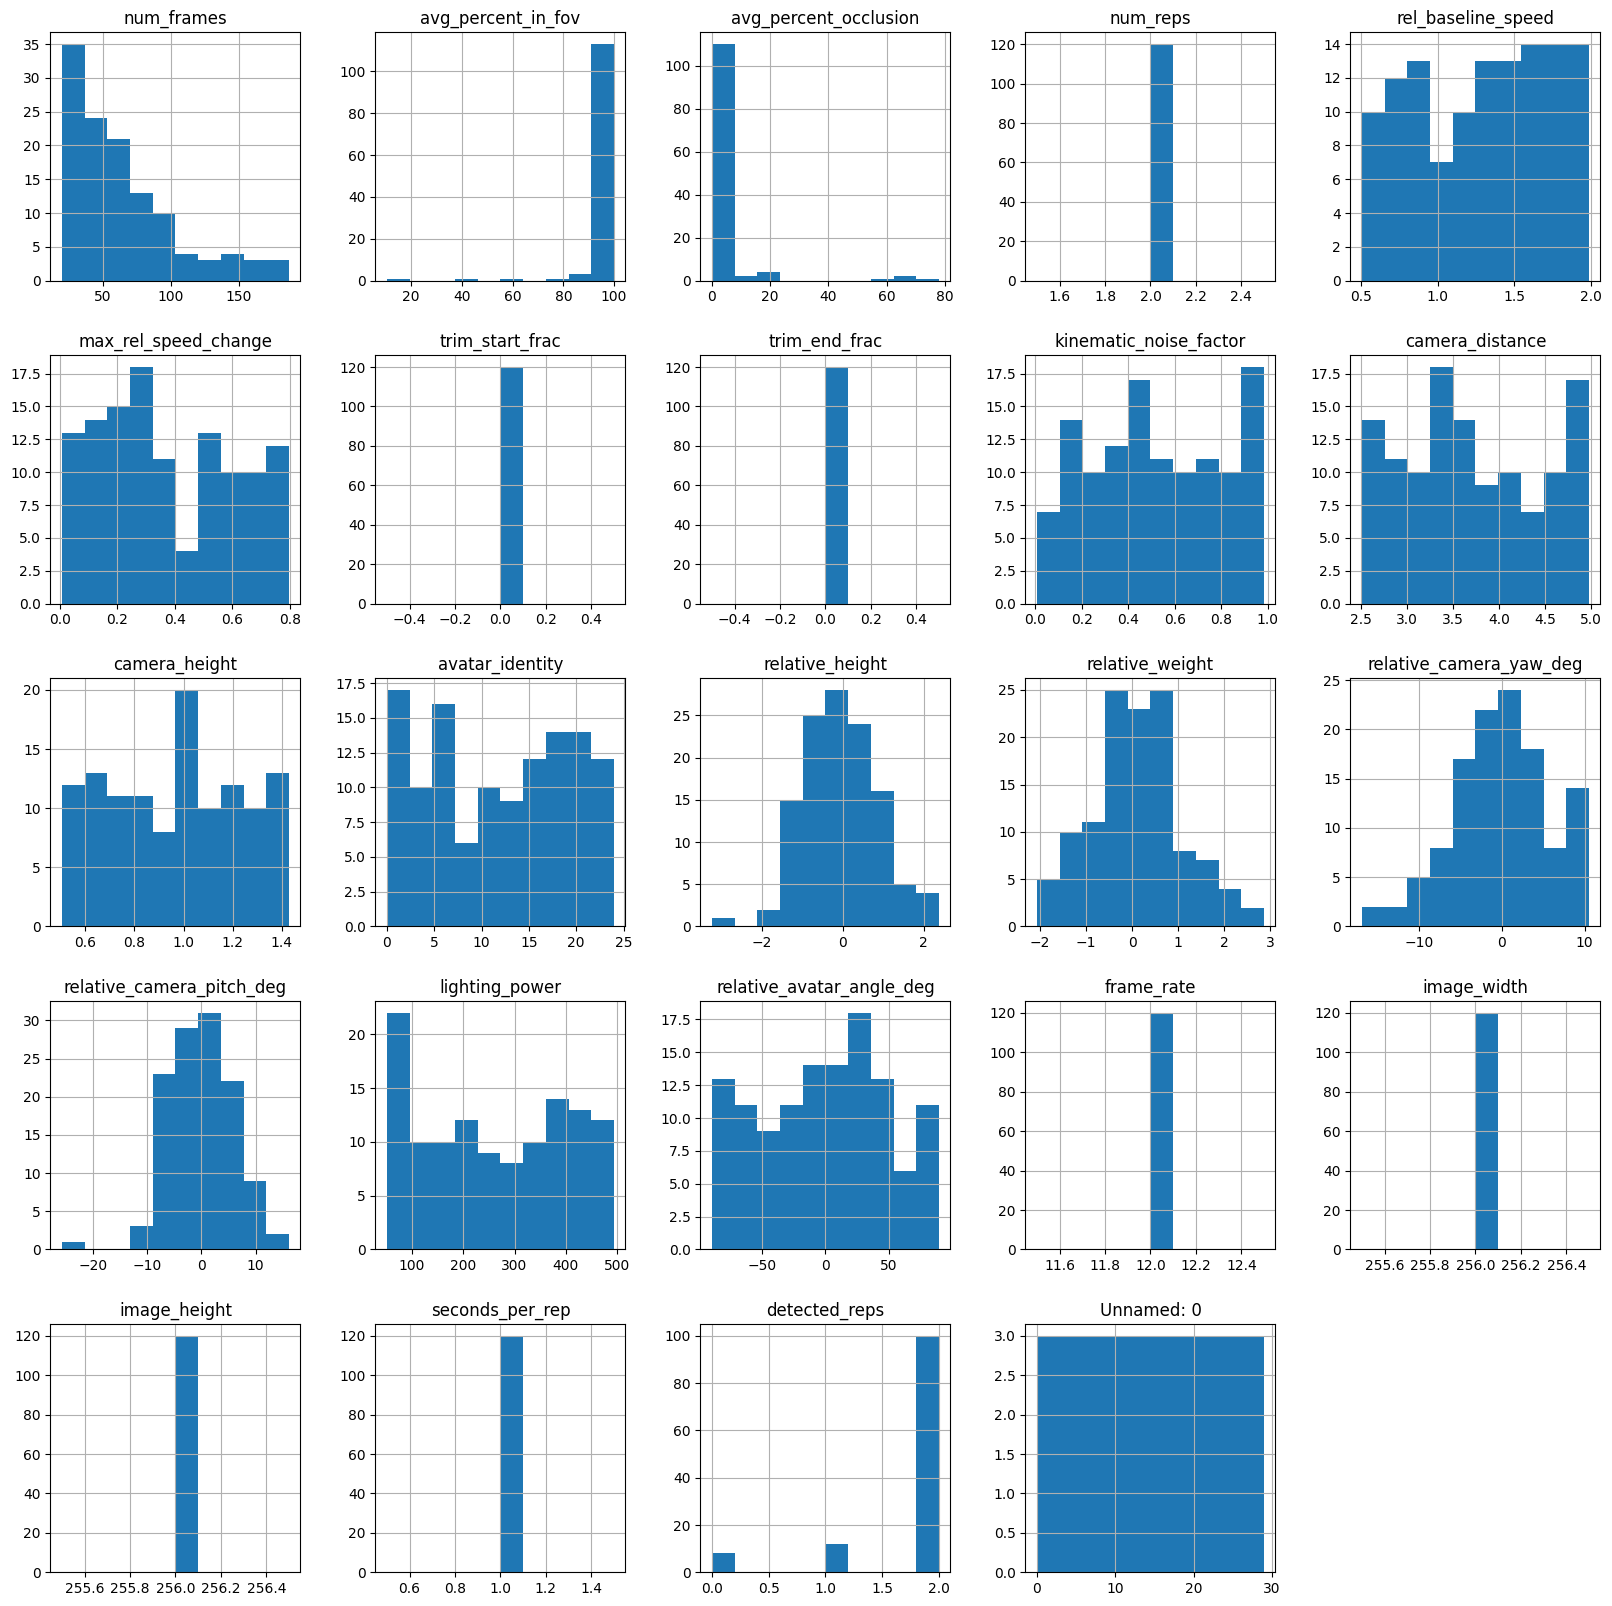

In [7]:
df_agg.hist(figsize=(20,20))